In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, RepeatedKFold
from scipy import sparse
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
from datetime import datetime

In [2]:
train_abbr=pd.read_excel("train_data.xlsx",encoding='ISO-8859-1')
train=pd.read_excel("train_data.xlsx",encoding='ISO-8859-1')
test_abbr=pd.read_excel("test_data.xlsx",encoding='ISO-8859-1')
test=pd.read_excel("test_data.xlsx",encoding='ISO-8859-1')
test_sub=pd.read_excel("result.xlsx",encoding='ISO-8859-1')

In [3]:
test.shape

(96, 12)

In [4]:
test_sub.shape

(0, 0)

In [5]:
train.shape

(7200, 12)

In [6]:
train.head()

,date,time,price1,MW1,MW2,MW3,MW4,MW5,MW6,MW7,pub1,pub2
0,2022-01-01,00:15:00,279.0,60624.3,10030.0,8817.99,0.0,4815,8140,36961.31,18392.6,8051.86
1,2022-01-01,00:30:00,277.0,60527.7,9443.0,8895.40,0.0,4815,8140,37374.30,17979.7,8464.77
2,2022-01-01,00:45:00,277.4,59883.2,9206.0,8969.26,0.0,4815,8140,36892.94,18461.1,7983.40
3,2022-01-01,01:00:00,276.0,59625.4,8969.0,9038.97,0.0,4815,8140,36802.43,18551.6,7892.89
4,2022-01-01,01:15:00,275.0,59367.6,8732.0,9104.96,0.0,4815,8140,36715.64,18638.4,7806.09


In [7]:
train.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    7200 non-null   datetime64[ns]
 1   time    7200 non-null   object        
 2   price1  7200 non-null   float64       
 3   MW1     7200 non-null   float64       
 4   MW2     7200 non-null   float64       
 5   MW3     7200 non-null   float64       
 6   MW4     7200 non-null   float64       
 7   MW5     7200 non-null   int64         
 8   MW6     7200 non-null   int64         
 9   MW7     7200 non-null   float64       
 10  pub1    7200 non-null   float64       
 11  pub2    7200 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(2), object(1)
memory usage: 675.1+ KB


In [8]:
y_train_=train["price1"]

In [9]:
y_train_.value_counts()

-80.00      906
 500.00      25
 375.00      25
 408.00      24
 420.00      23
 424.00      20
 380.00      19
 450.00      18
 300.00      18
 360.00      18
 442.00      17
 410.00      16
 370.00      16
 416.00      16
 390.00      16
 432.00      16
 402.00      15
 422.00      15
 438.00      15
 372.00      15
 412.00      15
 404.00      15
 0.00        14
 406.00      13
 250.00      13
 373.00      12
 378.00      12
 400.00      12
 498.00      12
 506.00      11
 544.00      11
 428.00      11
 458.00      11
 374.00      11
 434.00      10
 340.00      10
 350.00      10
 426.00      10
 230.00      10
 200.00      10
 418.00      10
 240.00      10
 216.00       9
 460.00       9
 580.00       9
 427.00       9
 476.00       9
 454.00       9
 385.00       9
 276.00       9
 120.00       9
 212.00       9
 371.67       9
 362.00       9
 456.00       8
 367.00       8
 393.00       8
 382.00       8
 358.00       8
 446.00       8
 236.00       8
 444.00       8
 178.00 

In [10]:
y_train_=y_train_.map(lambda x:3 if x==-8 else x)

In [11]:
data=pd.concat([train,test],axis=0,ignore_index=True)

In [12]:
data.shape

(7296, 12)

In [13]:
print(data)

           date      time   price1      MW1       MW2       MW3      MW4  \
0    2022-01-01  00:15:00   279.00  60624.3  10030.00   8817.99     0.00   
1    2022-01-01  00:30:00   277.00  60527.7   9443.00   8895.40     0.00   
2    2022-01-01  00:45:00   277.40  59883.2   9206.00   8969.26     0.00   
3    2022-01-01  01:00:00   276.00  59625.4   8969.00   9038.97     0.00   
4    2022-01-01  01:15:00   275.00  59367.6   8732.00   9104.96     0.00   
5    2022-01-01  01:30:00   275.00  59109.8   8495.00   9170.70     0.00   
6    2022-01-01  01:45:00   275.00  58851.9   8258.00   9235.90     0.00   
7    2022-01-01  02:00:00   273.00  58276.3   8023.00   9300.84     0.00   
8    2022-01-01  02:15:00   266.40  58107.0   8023.00   9357.70     0.00   
9    2022-01-01  02:30:00   259.52  58005.4   8023.00   9409.81     0.00   
10   2022-01-01  02:45:00   252.00  57666.8   8023.00   9462.21     0.00   
11   2022-01-01  03:00:00   248.05  57565.2   8023.00   9519.31     0.00   
12   2022-01

In [14]:
data=data.drop(["date"], axis=1)
data=data.drop(["time"], axis=1)
#data=data.drop(["price1"], axis=1)

In [15]:
#data=data.drop(["id"], axis=1)
print(data)

       price1      MW1       MW2       MW3      MW4   MW5   MW6       MW7  \
0      279.00  60624.3  10030.00   8817.99     0.00  4815  8140  36961.31   
1      277.00  60527.7   9443.00   8895.40     0.00  4815  8140  37374.30   
2      277.40  59883.2   9206.00   8969.26     0.00  4815  8140  36892.94   
3      276.00  59625.4   8969.00   9038.97     0.00  4815  8140  36802.43   
4      275.00  59367.6   8732.00   9104.96     0.00  4815  8140  36715.64   
5      275.00  59109.8   8495.00   9170.70     0.00  4815  8140  36629.10   
6      275.00  58851.9   8258.00   9235.90     0.00  4815  8140  36543.00   
7      273.00  58276.3   8023.00   9300.84     0.00  4815  8140  36137.46   
8      266.40  58107.0   8023.00   9357.70     0.00  4815  8140  35911.30   
9      259.52  58005.4   8023.00   9409.81     0.00  4815  8140  35757.59   
10     252.00  57666.8   8023.00   9462.21     0.00  4815  8140  35366.59   
11     248.05  57565.2   8023.00   9519.31     0.00  4815  8140  35207.89   

In [16]:
data["price1"]=data["price1"].map(lambda x:x-1)

In [17]:
X_train_ = data[:train.shape[0]]
X_test_  = data[train.shape[0]:]

In [18]:
target_column = 'price1'
feature_columns=list(X_test_.columns) 
feature_columns

['price1', 'MW1', 'MW2', 'MW3', 'MW4', 'MW5', 'MW6', 'MW7', 'pub1', 'pub2']

In [19]:
X_train = np.array(X_train_)
y_train = np.array(y_train_)
X_test  = np.array(X_test_)

In [20]:
X_train.shape

(7200, 10)

In [21]:
y_train.shape

(7200,)

In [22]:
X_test.shape

(96, 10)

In [23]:
#自定义评价函数
def myFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)
    return 'myFeval',score

In [24]:
##### xgb，'silent': True,

xgb_params = {"booster":'gbtree','eta': 0.005, 'max_depth': 5, 'subsample': 0.7, 
              'colsample_bytree': 0.8, 'objective': 'reg:linear', 'eval_metric': 'rmse',  'nthread': 8}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])
    
    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params,feval = myFeval)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, y_train_)))

fold n°1
[23:54:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:400.79132	train-myFeval:160633.67188	valid_data-rmse:400.03970	valid_data-myFeval:160031.75000
[100]	train-rmse:246.04652	train-myFeval:60538.89453	valid_data-rmse:245.73994	valid_data-myFeval:60388.12891
[200]	train-rmse:151.38170	train-myFeval:22916.41211	valid_data-rmse:151.25297	valid_data-myFeval:22877.45898
[300]	train-rmse:93.28451	train-myFeval:8702.00293	valid_data-rmse:93.19634	valid_data-myFeval:8685.55859
[400]	train-rmse:58.08651	train-myFeval:3374.04370	valid_data-rmse:58.19135	valid_data-myFeval:3386.23340
[500]	train-rmse:36.53605	train-myFeval:1334.88281	valid_data-rmse:36.82655	valid_data-myFeval:1356.19519
[600]	train-rmse:23.26713	train-myFeval:541.35913	valid_data-rmse:23.77174	valid_data-myFeval:565.09576
[700]	train-rmse:15.38962	train-myFeval:236.84039	valid_data-r

[8000]	train-rmse:1.02970	train-myFeval:1.06027	valid_data-rmse:3.62385	valid_data-myFeval:13.13228
[8100]	train-rmse:1.01941	train-myFeval:1.03920	valid_data-rmse:3.61886	valid_data-myFeval:13.09615
[8200]	train-rmse:1.00958	train-myFeval:1.01926	valid_data-rmse:3.61449	valid_data-myFeval:13.06456
[8300]	train-rmse:0.99946	train-myFeval:0.99893	valid_data-rmse:3.61011	valid_data-myFeval:13.03286
[8400]	train-rmse:0.99019	train-myFeval:0.98048	valid_data-rmse:3.60594	valid_data-myFeval:13.00278
[8500]	train-rmse:0.98026	train-myFeval:0.96091	valid_data-rmse:3.60141	valid_data-myFeval:12.97018
[8600]	train-rmse:0.97128	train-myFeval:0.94338	valid_data-rmse:3.59791	valid_data-myFeval:12.94499
[8700]	train-rmse:0.96213	train-myFeval:0.92570	valid_data-rmse:3.59423	valid_data-myFeval:12.91851
[8800]	train-rmse:0.95306	train-myFeval:0.90833	valid_data-rmse:3.59055	valid_data-myFeval:12.89202
[8900]	train-rmse:0.94450	train-myFeval:0.89208	valid_data-rmse:3.58675	valid_data-myFeval:12.86481


[16200]	train-rmse:0.53147	train-myFeval:0.28246	valid_data-rmse:3.43756	valid_data-myFeval:11.81679
[16300]	train-rmse:0.52806	train-myFeval:0.27885	valid_data-rmse:3.43651	valid_data-myFeval:11.80963
[16400]	train-rmse:0.52436	train-myFeval:0.27496	valid_data-rmse:3.43541	valid_data-myFeval:11.80205
[16500]	train-rmse:0.52096	train-myFeval:0.27140	valid_data-rmse:3.43433	valid_data-myFeval:11.79462
[16600]	train-rmse:0.51754	train-myFeval:0.26785	valid_data-rmse:3.43325	valid_data-myFeval:11.78721
[16700]	train-rmse:0.51420	train-myFeval:0.26440	valid_data-rmse:3.43242	valid_data-myFeval:11.78148
[16800]	train-rmse:0.51078	train-myFeval:0.26089	valid_data-rmse:3.43157	valid_data-myFeval:11.77568
[16900]	train-rmse:0.50740	train-myFeval:0.25745	valid_data-rmse:3.43086	valid_data-myFeval:11.77077
[17000]	train-rmse:0.50403	train-myFeval:0.25405	valid_data-rmse:3.42986	valid_data-myFeval:11.76395
[17100]	train-rmse:0.50067	train-myFeval:0.25067	valid_data-rmse:3.42871	valid_data-myFeval

D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


fold n°2
[23:57:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:401.72562	train-myFeval:161383.48438	valid_data-rmse:396.28900	valid_data-myFeval:157044.96875
[100]	train-rmse:246.57353	train-myFeval:60798.52344	valid_data-rmse:243.08539	valid_data-myFeval:59090.50391
[200]	train-rmse:151.71857	train-myFeval:23018.52344	valid_data-rmse:149.66888	valid_data-myFeval:22400.77734
[300]	train-rmse:93.46381	train-myFeval:8735.48340	valid_data-rmse:92.45966	valid_data-myFeval:8548.78906
[400]	train-rmse:58.19151	train-myFeval:3386.25171	valid_data-rmse:57.88348	valid_data-myFeval:3350.49731
[500]	train-rmse:36.58721	train-myFeval:1338.62390	valid_data-rmse:36.75895	valid_data-myFeval:1351.22083
[600]	train-rmse:23.30149	train-myFeval:542.95917	valid_data-rmse:23.86344	valid_data-myFeval:569.46399
[700]	train-rmse:15.43085	train-myFeval:238.11128	valid_data-r

[8000]	train-rmse:1.11175	train-myFeval:1.23598	valid_data-rmse:3.30932	valid_data-myFeval:10.95159
[8100]	train-rmse:1.10031	train-myFeval:1.21068	valid_data-rmse:3.30332	valid_data-myFeval:10.91193
[8200]	train-rmse:1.08952	train-myFeval:1.18706	valid_data-rmse:3.29796	valid_data-myFeval:10.87655
[8300]	train-rmse:1.07859	train-myFeval:1.16335	valid_data-rmse:3.29237	valid_data-myFeval:10.83972
[8400]	train-rmse:1.06808	train-myFeval:1.14080	valid_data-rmse:3.28663	valid_data-myFeval:10.80195
[8500]	train-rmse:1.05756	train-myFeval:1.11844	valid_data-rmse:3.28059	valid_data-myFeval:10.76225
[8600]	train-rmse:1.04758	train-myFeval:1.09743	valid_data-rmse:3.27540	valid_data-myFeval:10.72823
[8700]	train-rmse:1.03713	train-myFeval:1.07563	valid_data-rmse:3.26964	valid_data-myFeval:10.69052
[8800]	train-rmse:1.02675	train-myFeval:1.05420	valid_data-rmse:3.26377	valid_data-myFeval:10.65219
[8900]	train-rmse:1.01753	train-myFeval:1.03536	valid_data-rmse:3.25922	valid_data-myFeval:10.62254


[16200]	train-rmse:0.56612	train-myFeval:0.32049	valid_data-rmse:3.06707	valid_data-myFeval:9.40690
[16300]	train-rmse:0.56210	train-myFeval:0.31596	valid_data-rmse:3.06579	valid_data-myFeval:9.39906
[16400]	train-rmse:0.55804	train-myFeval:0.31141	valid_data-rmse:3.06437	valid_data-myFeval:9.39034
[16500]	train-rmse:0.55406	train-myFeval:0.30698	valid_data-rmse:3.06325	valid_data-myFeval:9.38349
[16600]	train-rmse:0.55021	train-myFeval:0.30273	valid_data-rmse:3.06195	valid_data-myFeval:9.37551
[16700]	train-rmse:0.54674	train-myFeval:0.29893	valid_data-rmse:3.06105	valid_data-myFeval:9.37000
[16800]	train-rmse:0.54303	train-myFeval:0.29489	valid_data-rmse:3.05980	valid_data-myFeval:9.36237
[16900]	train-rmse:0.53932	train-myFeval:0.29087	valid_data-rmse:3.05872	valid_data-myFeval:9.35578
[17000]	train-rmse:0.53572	train-myFeval:0.28700	valid_data-rmse:3.05750	valid_data-myFeval:9.34830
[17100]	train-rmse:0.53224	train-myFeval:0.28328	valid_data-rmse:3.05616	valid_data-myFeval:9.34012


D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


fold n°3
[00:00:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:398.63727	train-myFeval:158911.64062	valid_data-rmse:408.59994	valid_data-myFeval:166953.93750
[100]	train-rmse:244.66568	train-myFeval:59861.30469	valid_data-rmse:251.15350	valid_data-myFeval:63078.07812
[200]	train-rmse:150.53426	train-myFeval:22660.56055	valid_data-rmse:154.79561	valid_data-myFeval:23961.67969
[300]	train-rmse:92.73422	train-myFeval:8599.63574	valid_data-rmse:95.68027	valid_data-myFeval:9154.71484
[400]	train-rmse:57.73450	train-myFeval:3333.27319	valid_data-rmse:60.05829	valid_data-myFeval:3606.99780
[500]	train-rmse:36.32840	train-myFeval:1319.75317	valid_data-rmse:38.38860	valid_data-myFeval:1473.68433
[600]	train-rmse:23.15139	train-myFeval:535.98657	valid_data-rmse:25.12304	valid_data-myFeval:631.16699
[700]	train-rmse:15.34490	train-myFeval:235.46596	valid_data-r

[8000]	train-rmse:1.05846	train-myFeval:1.12035	valid_data-rmse:3.83828	valid_data-myFeval:14.73243
[8100]	train-rmse:1.04844	train-myFeval:1.09923	valid_data-rmse:3.83441	valid_data-myFeval:14.70270
[8200]	train-rmse:1.03886	train-myFeval:1.07923	valid_data-rmse:3.83034	valid_data-myFeval:14.67150
[8300]	train-rmse:1.02825	train-myFeval:1.05730	valid_data-rmse:3.82617	valid_data-myFeval:14.63960
[8400]	train-rmse:1.01845	train-myFeval:1.03724	valid_data-rmse:3.82172	valid_data-myFeval:14.60558
[8500]	train-rmse:1.00875	train-myFeval:1.01758	valid_data-rmse:3.81766	valid_data-myFeval:14.57454
[8600]	train-rmse:0.99923	train-myFeval:0.99846	valid_data-rmse:3.81369	valid_data-myFeval:14.54421
[8700]	train-rmse:0.98978	train-myFeval:0.97967	valid_data-rmse:3.81004	valid_data-myFeval:14.51640
[8800]	train-rmse:0.98021	train-myFeval:0.96082	valid_data-rmse:3.80618	valid_data-myFeval:14.48698
[8900]	train-rmse:0.97088	train-myFeval:0.94261	valid_data-rmse:3.80261	valid_data-myFeval:14.45981


[16200]	train-rmse:0.54845	train-myFeval:0.30080	valid_data-rmse:3.65964	valid_data-myFeval:13.39299
[16300]	train-rmse:0.54448	train-myFeval:0.29646	valid_data-rmse:3.65867	valid_data-myFeval:13.38588
[16400]	train-rmse:0.54077	train-myFeval:0.29243	valid_data-rmse:3.65756	valid_data-myFeval:13.37772
[16500]	train-rmse:0.53736	train-myFeval:0.28876	valid_data-rmse:3.65652	valid_data-myFeval:13.37015
[16600]	train-rmse:0.53351	train-myFeval:0.28464	valid_data-rmse:3.65557	valid_data-myFeval:13.36317
[16700]	train-rmse:0.52994	train-myFeval:0.28083	valid_data-rmse:3.65474	valid_data-myFeval:13.35714
[16800]	train-rmse:0.52619	train-myFeval:0.27688	valid_data-rmse:3.65390	valid_data-myFeval:13.35101
[16900]	train-rmse:0.52270	train-myFeval:0.27322	valid_data-rmse:3.65298	valid_data-myFeval:13.34423
[17000]	train-rmse:0.51926	train-myFeval:0.26963	valid_data-rmse:3.65202	valid_data-myFeval:13.33727
[17100]	train-rmse:0.51562	train-myFeval:0.26587	valid_data-rmse:3.65073	valid_data-myFeval

D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


fold n°4
[00:03:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:401.76071	train-myFeval:161411.57812	valid_data-rmse:396.15814	valid_data-myFeval:156941.25000
[100]	train-rmse:246.66010	train-myFeval:60841.21094	valid_data-rmse:243.47519	valid_data-myFeval:59280.16797
[200]	train-rmse:151.78197	train-myFeval:23037.76367	valid_data-rmse:150.10588	valid_data-myFeval:22531.77734
[300]	train-rmse:93.51434	train-myFeval:8744.93066	valid_data-rmse:92.75716	valid_data-myFeval:8603.89062
[400]	train-rmse:58.22963	train-myFeval:3390.68921	valid_data-rmse:58.10363	valid_data-myFeval:3376.03125
[500]	train-rmse:36.61914	train-myFeval:1340.96106	valid_data-rmse:36.89260	valid_data-myFeval:1361.06409
[600]	train-rmse:23.32916	train-myFeval:544.24994	valid_data-rmse:23.90782	valid_data-myFeval:571.58411
[700]	train-rmse:15.45514	train-myFeval:238.86137	valid_data-r

[8000]	train-rmse:1.03970	train-myFeval:1.08097	valid_data-rmse:3.27878	valid_data-myFeval:10.75037
[8100]	train-rmse:1.02903	train-myFeval:1.05890	valid_data-rmse:3.27314	valid_data-myFeval:10.71344
[8200]	train-rmse:1.01990	train-myFeval:1.04020	valid_data-rmse:3.26863	valid_data-myFeval:10.68396
[8300]	train-rmse:1.00954	train-myFeval:1.01918	valid_data-rmse:3.26336	valid_data-myFeval:10.64954
[8400]	train-rmse:0.99949	train-myFeval:0.99898	valid_data-rmse:3.25878	valid_data-myFeval:10.61964
[8500]	train-rmse:0.98954	train-myFeval:0.97919	valid_data-rmse:3.25416	valid_data-myFeval:10.58957
[8600]	train-rmse:0.97958	train-myFeval:0.95958	valid_data-rmse:3.24969	valid_data-myFeval:10.56049
[8700]	train-rmse:0.97037	train-myFeval:0.94163	valid_data-rmse:3.24527	valid_data-myFeval:10.53177
[8800]	train-rmse:0.96084	train-myFeval:0.92321	valid_data-rmse:3.24080	valid_data-myFeval:10.50281
[8900]	train-rmse:0.95170	train-myFeval:0.90574	valid_data-rmse:3.23656	valid_data-myFeval:10.47532


[16200]	train-rmse:0.53388	train-myFeval:0.28503	valid_data-rmse:3.08009	valid_data-myFeval:9.48694
[16300]	train-rmse:0.53034	train-myFeval:0.28125	valid_data-rmse:3.07893	valid_data-myFeval:9.47982
[16400]	train-rmse:0.52670	train-myFeval:0.27741	valid_data-rmse:3.07792	valid_data-myFeval:9.47360
[16500]	train-rmse:0.52313	train-myFeval:0.27367	valid_data-rmse:3.07679	valid_data-myFeval:9.46665
[16600]	train-rmse:0.51950	train-myFeval:0.26988	valid_data-rmse:3.07546	valid_data-myFeval:9.45846
[16700]	train-rmse:0.51604	train-myFeval:0.26630	valid_data-rmse:3.07440	valid_data-myFeval:9.45196
[16800]	train-rmse:0.51253	train-myFeval:0.26268	valid_data-rmse:3.07329	valid_data-myFeval:9.44514
[16900]	train-rmse:0.50912	train-myFeval:0.25921	valid_data-rmse:3.07233	valid_data-myFeval:9.43922
[17000]	train-rmse:0.50562	train-myFeval:0.25566	valid_data-rmse:3.07126	valid_data-myFeval:9.43264
[17100]	train-rmse:0.50232	train-myFeval:0.25232	valid_data-rmse:3.07041	valid_data-myFeval:9.42738


D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


fold n°5
[00:06:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:400.30249	train-myFeval:160242.01562	valid_data-rmse:402.01025	valid_data-myFeval:161612.21875
[100]	train-rmse:245.78201	train-myFeval:60408.80469	valid_data-rmse:247.03656	valid_data-myFeval:61027.06250
[200]	train-rmse:151.27019	train-myFeval:22882.66992	valid_data-rmse:152.17775	valid_data-myFeval:23158.06641
[300]	train-rmse:93.22930	train-myFeval:8691.70312	valid_data-rmse:93.89009	valid_data-myFeval:8815.34863
[400]	train-rmse:58.06797	train-myFeval:3371.88818	valid_data-rmse:58.60114	valid_data-myFeval:3434.09399
[500]	train-rmse:36.53795	train-myFeval:1335.02222	valid_data-rmse:37.05561	valid_data-myFeval:1373.11853
[600]	train-rmse:23.27134	train-myFeval:541.55548	valid_data-rmse:23.80032	valid_data-myFeval:566.45502
[700]	train-rmse:15.40574	train-myFeval:237.33697	valid_data-r

[8000]	train-rmse:1.03737	train-myFeval:1.07614	valid_data-rmse:2.86017	valid_data-myFeval:8.18060
[8100]	train-rmse:1.02734	train-myFeval:1.05543	valid_data-rmse:2.85637	valid_data-myFeval:8.15883
[8200]	train-rmse:1.01687	train-myFeval:1.03402	valid_data-rmse:2.85189	valid_data-myFeval:8.13326
[8300]	train-rmse:1.00614	train-myFeval:1.01232	valid_data-rmse:2.84719	valid_data-myFeval:8.10651
[8400]	train-rmse:0.99569	train-myFeval:0.99141	valid_data-rmse:2.84252	valid_data-myFeval:8.07989
[8500]	train-rmse:0.98587	train-myFeval:0.97195	valid_data-rmse:2.83862	valid_data-myFeval:8.05775
[8600]	train-rmse:0.97665	train-myFeval:0.95385	valid_data-rmse:2.83486	valid_data-myFeval:8.03645
[8700]	train-rmse:0.96743	train-myFeval:0.93592	valid_data-rmse:2.83126	valid_data-myFeval:8.01600
[8800]	train-rmse:0.95855	train-myFeval:0.91882	valid_data-rmse:2.82796	valid_data-myFeval:7.99734
[8900]	train-rmse:0.94946	train-myFeval:0.90147	valid_data-rmse:2.82463	valid_data-myFeval:7.97855
[9000]	tra

[16300]	train-rmse:0.53039	train-myFeval:0.28132	valid_data-rmse:2.67822	valid_data-myFeval:7.17288
[16400]	train-rmse:0.52666	train-myFeval:0.27737	valid_data-rmse:2.67742	valid_data-myFeval:7.16856
[16500]	train-rmse:0.52312	train-myFeval:0.27365	valid_data-rmse:2.67616	valid_data-myFeval:7.16184
[16600]	train-rmse:0.51976	train-myFeval:0.27015	valid_data-rmse:2.67502	valid_data-myFeval:7.15573
[16700]	train-rmse:0.51644	train-myFeval:0.26671	valid_data-rmse:2.67414	valid_data-myFeval:7.15101
[16800]	train-rmse:0.51311	train-myFeval:0.26328	valid_data-rmse:2.67325	valid_data-myFeval:7.14625
[16900]	train-rmse:0.50952	train-myFeval:0.25961	valid_data-rmse:2.67205	valid_data-myFeval:7.13986
[17000]	train-rmse:0.50606	train-myFeval:0.25610	valid_data-rmse:2.67100	valid_data-myFeval:7.13424
[17100]	train-rmse:0.50275	train-myFeval:0.25276	valid_data-rmse:2.67015	valid_data-myFeval:7.12967
[17200]	train-rmse:0.49911	train-myFeval:0.24911	valid_data-rmse:2.66921	valid_data-myFeval:7.12470


D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


CV score: 10.04234617


In [25]:
##### lgb

param = {'boosting_type': 'gbdt',
         'num_leaves': 20,
         'min_data_in_leaf': 20, 
         'objective':'regression',
         'max_depth':6,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(X_train_))
predictions_lgb = np.zeros(len(X_test_))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
   # print(trn_idx)
   # print(".............x_train.........")
   # print(X_train[trn_idx])
  #  print(".............y_train.........")
  #  print(y_train[trn_idx])
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, y_train_)))

fold n°1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 100 rounds


D:\Application\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Application\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	training's l2: 1423.47	valid_1's l2: 1429.83
[400]	training's l2: 105.846	valid_1's l2: 122.221
[600]	training's l2: 39.6842	valid_1's l2: 58.2612
[800]	training's l2: 26.0999	valid_1's l2: 45.4231
[1000]	training's l2: 20.8477	valid_1's l2: 40.8553
[1200]	training's l2: 17.6532	valid_1's l2: 37.8457
[1400]	training's l2: 15.2989	valid_1's l2: 35.7867
[1600]	training's l2: 13.6072	valid_1's l2: 34.4336
[1800]	training's l2: 12.2903	valid_1's l2: 33.3838
[2000]	training's l2: 11.2994	valid_1's l2: 32.5419
[2200]	training's l2: 10.4289	valid_1's l2: 31.9291
[2400]	training's l2: 9.6547	valid_1's l2: 31.4289
[2600]	training's l2: 9.02855	valid_1's l2: 30.9666
[2800]	training's l2: 8.44391	valid_1's l2: 30.4993
[3000]	training's l2: 7.93355	valid_1's l2: 29.9972
[3200]	training's l2: 7.46662	valid_1's l2: 29.7371
[3400]	training's l2: 7.07067	valid_1's l2: 29.3775
[3600]	training's l2: 6.72243	valid_1's l2: 29.1412
[3800]	training's l2: 6.37878	valid_1's l2: 28.7669
[4000]	training's

[200]	training's l2: 1435.35	valid_1's l2: 1430.6
[400]	training's l2: 106.148	valid_1's l2: 116.027
[600]	training's l2: 38.834	valid_1's l2: 46.3142
[800]	training's l2: 24.9357	valid_1's l2: 31.9186
[1000]	training's l2: 19.2986	valid_1's l2: 26.4784
[1200]	training's l2: 16.1078	valid_1's l2: 23.1479
[1400]	training's l2: 14.0292	valid_1's l2: 21.2423
[1600]	training's l2: 12.5293	valid_1's l2: 19.9274
[1800]	training's l2: 11.322	valid_1's l2: 18.9223
[2000]	training's l2: 10.4027	valid_1's l2: 18.1594
[2200]	training's l2: 9.63506	valid_1's l2: 17.6438
[2400]	training's l2: 8.95792	valid_1's l2: 17.1958
[2600]	training's l2: 8.32575	valid_1's l2: 16.7682
[2800]	training's l2: 7.77294	valid_1's l2: 16.416
[3000]	training's l2: 7.33292	valid_1's l2: 16.1402
[3200]	training's l2: 6.92525	valid_1's l2: 15.8838
[3400]	training's l2: 6.53716	valid_1's l2: 15.6454
[3600]	training's l2: 6.19425	valid_1's l2: 15.4058
[3800]	training's l2: 5.88577	valid_1's l2: 15.2206
[4000]	training's l2

In [26]:
from catboost import Pool, CatBoostRegressor
# cat_features=[0,2,3,10,11,13,15,16,17,18,19]
from sklearn.model_selection import train_test_split


#X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train_, y_train_, test_size=0.3, random_state=2019)
# train_pool = Pool(X_train_s, y_train_s,cat_features=[0,2,3,10,11,13,15,16,17,18,19])
# val_pool = Pool(X_test_s, y_test_s,cat_features=[0,2,3,10,11,13,15,16,17,18,19])
# test_pool = Pool(X_test_ ,cat_features=[0,2,3,10,11,13,15,16,17,18,19]) 


kfolder = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_cb = np.zeros(len(X_train_))
predictions_cb = np.zeros(len(X_test_))
kfold = kfolder.split(X_train_, y_train_)
fold_=0
#X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.3, random_state=2019)
for train_index, vali_index in kfold:
    print("fold n°{}".format(fold_))
    fold_=fold_+1
    k_x_train = X_train[train_index]
    k_y_train = y_train[train_index]
    k_x_vali = X_train[vali_index]
    k_y_vali = y_train[vali_index]
    cb_params = {
         'n_estimators': 100000,
         'loss_function': 'RMSE',
         'eval_metric':'RMSE',
         'learning_rate': 0.05,
         'depth': 5,
         'use_best_model': True,
         'subsample': 0.6,
         'bootstrap_type': 'Bernoulli',
         'reg_lambda': 3
    }
    model_cb = CatBoostRegressor(**cb_params)
    #train the model
    model_cb.fit(k_x_train, k_y_train,eval_set=[(k_x_vali, k_y_vali)],verbose=100,early_stopping_rounds=50)
    oof_cb[vali_index] = model_cb.predict(k_x_vali, ntree_end=model_cb.best_iteration_)
    predictions_cb += model_cb.predict(X_test_, ntree_end=model_cb.best_iteration_) / kfolder.n_splits



print("CV score: {:<8.8f}".format(mean_squared_error(oof_cb, y_train_)))


fold n°0
0:	learn: 225.0377779	test: 228.0644032	best: 228.0644032 (0)	total: 149ms	remaining: 4h 7m 41s
100:	learn: 8.9776700	test: 9.8529121	best: 9.8529121 (100)	total: 371ms	remaining: 6m 6s
200:	learn: 5.8520060	test: 6.4950145	best: 6.4950145 (200)	total: 569ms	remaining: 4m 42s
300:	learn: 4.8034962	test: 5.5429307	best: 5.5429307 (300)	total: 766ms	remaining: 4m 13s
400:	learn: 4.2008288	test: 5.0663564	best: 5.0663564 (400)	total: 958ms	remaining: 3m 57s
500:	learn: 3.7913482	test: 4.7439883	best: 4.7439883 (500)	total: 1.16s	remaining: 3m 50s
600:	learn: 3.5098109	test: 4.5644540	best: 4.5644540 (600)	total: 1.34s	remaining: 3m 41s
700:	learn: 3.2721578	test: 4.3950666	best: 4.3950666 (700)	total: 1.52s	remaining: 3m 35s
800:	learn: 3.0773760	test: 4.2731728	best: 4.2731728 (800)	total: 1.7s	remaining: 3m 30s
900:	learn: 2.9087751	test: 4.1839534	best: 4.1839534 (900)	total: 1.87s	remaining: 3m 25s
1000:	learn: 2.7821616	test: 4.1108597	best: 4.1089995 (996)	total: 2.07s	rema

1800:	learn: 1.9775596	test: 4.1396031	best: 4.1396031 (1800)	total: 3.74s	remaining: 3m 24s
1900:	learn: 1.9165561	test: 4.1257176	best: 4.1257176 (1900)	total: 3.93s	remaining: 3m 22s
2000:	learn: 1.8576174	test: 4.1057546	best: 4.1054947 (1997)	total: 4.11s	remaining: 3m 21s
2100:	learn: 1.8054331	test: 4.0950801	best: 4.0950801 (2100)	total: 4.32s	remaining: 3m 21s
2200:	learn: 1.7595240	test: 4.0816487	best: 4.0816487 (2200)	total: 4.5s	remaining: 3m 19s
2300:	learn: 1.7152940	test: 4.0729969	best: 4.0722477 (2297)	total: 4.72s	remaining: 3m 20s
2400:	learn: 1.6686558	test: 4.0615117	best: 4.0615117 (2400)	total: 4.92s	remaining: 3m 20s
2500:	learn: 1.6254820	test: 4.0535486	best: 4.0531907 (2498)	total: 5.12s	remaining: 3m 19s
2600:	learn: 1.5865056	test: 4.0450181	best: 4.0442082 (2598)	total: 5.33s	remaining: 3m 19s
2700:	learn: 1.5537819	test: 4.0414707	best: 4.0413321 (2686)	total: 5.52s	remaining: 3m 19s
2800:	learn: 1.5200590	test: 4.0375285	best: 4.0373266 (2769)	total: 5.

In [27]:
from sklearn import linear_model
# 将lgb和xgb和ctb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb,oof_cb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb,predictions_cb]).transpose()


folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2018)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,y_train)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], y_train[trn_idx]
    val_data, val_y = train_stack[val_idx], y_train[val_idx]
    
    clf_3 = linear_model.BayesianRidge()
    #clf_3 =linear_model.Ridge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_stack, y_train_)))


fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
CV score: 7.54349248


In [28]:
result=list(predictions)
result=list(map(lambda x: x + 1, result))
test_sub["price2"]=result
test_sub.to_csv("pre2.csv", index=False)

In [29]:
acc=test['price1']

In [30]:
yuan=train['price1']
print(yuan)

0        279.00
1        277.00
2        277.40
3        276.00
4        275.00
5        275.00
6        275.00
7        273.00
8        266.40
9        259.52
10       252.00
11       248.05
12       244.29
13       241.00
14       234.43
15       233.00
16       233.00
17       237.00
18       240.80
19       243.00
20       251.20
21       261.40
22       273.00
23       272.80
24       269.00
25       262.80
26       266.36
27       274.50
28       276.00
29       314.40
30       354.32
31       358.00
32       358.00
33       304.76
34       267.80
35       238.10
36       223.00
37       212.82
38       200.88
39        -0.87
40       -80.00
41       -80.00
42       -80.00
43       -80.00
44       -80.00
45       -80.00
46       -80.00
47       -80.00
48       -80.00
49       -80.00
50       -80.00
51       -80.00
52       -80.00
53       -80.00
54       -80.00
55       -80.00
56       -80.00
57       -80.00
58       213.00
59       244.00
60       281.50
61       363.86
62      

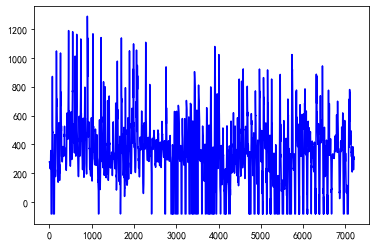

In [38]:
import matplotlib.pyplot as plt  
#plt.rcParams['font.sans-serif'] = [u'SimHei'] 
#plt.rcParams['axes.unicode_minus'] = False

plt.plot(yuan,color="b",label="acc") #颜色表示

In [31]:
pre_csv=pd.read_csv("pre2.csv",encoding='ISO-8859-1')
pre=pre_csv['price2']

In [32]:
pre=pre_csv['price2']

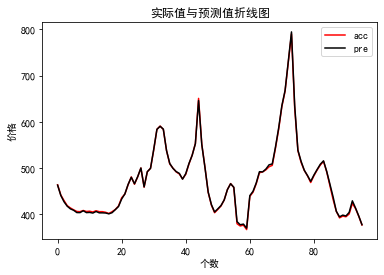

In [32]:
import matplotlib.pyplot as plt  
plt.rcParams['font.sans-serif'] = [u'SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
#acc 实际值数据

#pre 预测值数据
 
plt.plot(acc,color="r",label="acc") #颜色表示
 
plt.plot(pre,color=(0,0,0),label="pre") 
 
plt.xlabel("个数") 
 
plt.ylabel("价格") 
 
plt.title("实际值与预测值折线图") 
 
plt.legend()
 
plt.show() 

In [33]:
from sklearn.metrics import mean_squared_error,explained_variance_score,mean_absolute_error,r2_score

In [34]:
print ('均方差',mean_squared_error(acc,pre))
print ('绝对差',mean_absolute_error(acc,pre))
print ('解释度',explained_variance_score(acc,pre))

均方差 4.197439683647823
绝对差 1.5929282904130766
解释度 0.9993641524944775


In [38]:
print(acc)

0     464.00
1     442.00
2     430.00
3     419.00
4     414.00
5     410.00
6     406.44
7     406.00
8     408.56
9     406.40
10    407.00
11    405.28
12    408.00
13    406.00
14    406.00
15    404.66
16    402.00
17    406.00
18    410.66
19    418.24
20    436.00
21    444.00
22    464.00
23    481.00
24    465.32
25    481.20
26    500.32
27    459.00
28    492.00
29    499.77
30    539.00
31    584.00
32    591.00
33    583.60
34    538.00
35    509.13
36    500.00
37    492.00
38    487.38
39    476.90
40    486.68
41    509.00
42    528.00
43    553.00
44    650.76
45    551.80
46    501.79
47    447.83
48    420.16
49    403.72
50    410.84
51    418.28
52    431.32
53    453.60
54    466.80
55    458.00
56    380.00
57    375.08
58    376.92
59    367.32
60    439.00
61    448.10
62    466.42
63    490.00
64    492.00
65    496.30
66    503.00
67    506.00
68    543.00
69    584.00
70    633.20
71    666.32
72    728.40
73    790.00
74    629.80
75    538.00
76    512.40

In [39]:
print(pre)

0     463.316989
1     441.028436
2     427.404595
3     417.831758
4     412.052041
5     409.045140
6     404.061339
7     403.966316
8     407.995426
9     403.946305
10    404.401665
11    403.001351
12    406.398657
13    403.477926
14    403.466678
15    403.093398
16    401.366524
17    403.792728
18    410.300289
19    417.058738
20    433.439642
21    444.424354
22    464.809985
23    480.289410
24    466.295698
25    481.756106
26    500.316716
27    459.529150
28    492.377926
29    499.556244
30    540.705066
31    583.823761
32    590.395786
33    584.331364
34    537.946365
35    510.150557
36    499.683706
37    492.639923
38    488.647139
39    476.162528
40    488.198771
41    510.056527
42    527.809907
43    552.918264
44    645.978523
45    551.246272
46    501.104434
47    448.321784
48    421.421296
49    405.298517
50    412.045420
51    419.237635
52    431.365045
53    453.710842
54    466.349516
55    458.786069
56    384.494073
57    377.733634
58    379.1318

In [40]:
mape=np.abs((acc-pre)/((acc+pre)/2))
def average(maped):
    return float(sum(maped)/len(maped))
MAPE=average(mape)
print('mape:',MAPE)

mape: 0.0034484380097261364


In [35]:
print('percent:{:.2%}'.format(MAPE))

In [36]:
y_pred = np.array(pre)

In [37]:
print(y_true)

[ 317.3   290.8   235.6   173.2   118.8    93.     73.28   44.53    0.
  -80.    -80.    -80.    -80.    -80.    -80.    -80.    -80.    -80.
  -80.    -80.      0.     55.51   81.5    96.27  101.    126.    217.4
  248.6   240.    272.9   321.3   335.78  286.16  215.54  138.17   85.45
   52.44  -80.    -80.    -80.    -80.    -80.    -80.    -80.    -80.
  -80.    -80.    -80.    -80.    -80.    -80.    -80.    -80.    -80.
  -80.    -80.    -80.    -80.    -80.     55.     96.27  170.2   259.6
  364.4   394.    450.76  544.54  603.1   734.28  816.38  880.    942.69
  995.5  1021.34 1000.    985.    962.6   931.    922.42  893.82  924.36
  916.76  919.22  916.2   879.48  834.44  763.12  687.5   645.6   607.88
  570.8   560.    648.6   611.4   559.54  513.86]


In [46]:
print(pre)

0      316.683821
1      289.676916
2      233.639385
3      173.333700
4      117.030574
5       89.122923
6       72.010512
7       40.150409
8        0.077528
9      -77.118954
10     -77.262905
11     -78.080039
12     -79.426991
13     -78.943248
14     -77.368162
15     -77.392285
16     -77.379764
17     -77.570755
18     -79.453942
19     -77.912235
20      -0.094764
21      53.268921
22      77.546227
23      93.758955
24     100.817060
25     125.067047
26     215.525650
27     247.749631
28     239.379911
29     272.949221
30     321.070405
31     336.167115
32     285.645799
33     216.270558
34     136.589131
35      85.161276
36      49.484751
37     -79.876256
38     -80.155307
39     -78.988932
40     -78.816442
41     -78.170907
42     -78.112208
43     -78.285924
44     -79.279060
45     -78.886752
46     -78.145041
47     -78.674715
48     -79.161884
49     -79.150176
50     -79.048371
51     -78.949543
52     -78.466600
53     -79.137913
54     -80.358969
55     -78

In [53]:
mape0=np.mean(np.abs((acc-pre)/acc))*100

In [54]:
print(mape0)
#plt.plot(mape0,color="r",label="MAPE") #颜色表示


inf


In [58]:
y_pred1=np.round(y_pred)

In [59]:
print(y_pred1)

[425. 404. 380. ... 503. 472. 437.]


In [64]:
def mape(y_true, y_pred1):
    return np.mean(np.abs((y_pred1-y_true)/y_true))*100

def smape(y_true, y_pred1):
    return 2.0*np.mean(np.abs(y_pred1-y_true)/(np.abs(y_pred1)+np.abs(y_true)))*100


In [42]:
mape1=np.mean(np.abs((425.2326401 - 426) / 426)) * 100
print(mape1)

0.18013143192487652


In [ ]:
#smape,技术框架图,mae,mse;分母0-80，实际值，绝对值<100,可解释性方差，DARNN，Rmspe
#验证，测试集准确率% ，特征重要性，80训练-15验证-5测试（3.20-3.24）